In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# LAB MODULE 2.
# Observational data in climate science
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Topics covered:
# (1) Organization of geospatial data in python
# (2) Operations in time
# (3) Operations in space 

# The purpose of this exercise is to (partially) replicate the process of 
# building of a global mean tempertaure anomaly curve from observations 

# Links: 
#   https://journals.ametsoc.org/doi/pdf/10.1175/1520-0450%281986%29025%3C0161%3ANHSATV%3E2.0.CO%3B2
#   https://www.metoffice.gov.uk/hadobs/crutem4/data/download.html  >>>  CRUTEM.4.6.0.0.station_files.zip

In [2]:
# Libraries

import os

# A bunch of other libraries that may be useful (you can use them or ignore them, or import different ones)

import numpy as np
import pandas as pd
import geopandas as gpd

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
# Now let's have a look at one of them
# You can open the text files direclty with a text editor 
# Check as well the template with explanations: "crutem4_data_station_file_format.txt"

In [4]:
#-------------------------------------------------
#-- get info on database and files organization --
#-------------------------------------------------

flist = [os.path.join(path, name) for path, subdirs, files in os.walk("./CRUTEM.4.6.0.0.station_files/") for name in files]
for i in range(0,5):
  print (flist[i])

# exclude first 2 items, not relevant
flist=flist[2:]

# Alternativly
#import glob
#flist = glob.glob("./CRUTEM.4.6.0.0.station_files/"+'/*/*')

print ('\n',flist[0:5])
nst=len(flist)
print ("\n > Number of stations = ",nst)

./CRUTEM.4.6.0.0.station_files/Index
./CRUTEM.4.6.0.0.station_files/61/616120
./CRUTEM.4.6.0.0.station_files/61/612913
./CRUTEM.4.6.0.0.station_files/61/612770
./CRUTEM.4.6.0.0.station_files/61/614010

 ['./CRUTEM.4.6.0.0.station_files/61/612913', './CRUTEM.4.6.0.0.station_files/61/612770', './CRUTEM.4.6.0.0.station_files/61/614010', './CRUTEM.4.6.0.0.station_files/61/618470', './CRUTEM.4.6.0.0.station_files/61/614420']

 > Number of stations =  10294


In [5]:
# Task 1 
# We need to import the data in python and organize them for further analyses and operations, both in time and space.

# Try to start thinking of a suitable way to organize this dataset, consisting of ~10,000 stations, each one having:
# - a unique identifier
# - string metadata (e.g. name, country)
# - numerical metadata (e.g. latitude, longitude, elevation) >> lat & lon are also the spatial dimensions we'll need
# - other metadata
# - a time series at monthly resolution oragnized as 2D tabs (year, month)

# Consider the data structures you know of, keeping in mind the final purpose that will require somehow 
# aggregating this dataset in time and space. 

# Bear in mind that this is real raw data that could have incomplete/erroneous file coding etc.
# Other than that, we will assume that all the reported data are correct and directly usable, 
#   considering the reality that time series have missing data and different time span.

In [6]:
# We will consider the actual time & space operation in the next stages.

In [7]:
# We are back !
# Here are a few initial considerations.

# First, let's start from the consideration that time series have missing data and different time span.
# In order to oraganize temporal data coherently, we need a common time axis, on which to place correctly our obs.
# >> datetime objects provide this kind of functionality

# The time series are currently organized as inpependent 2D tabs; 
# it will be necessary to expand them into 1D time series

# In this way we could associate a 1D time series to each station;
# a pandas dataframe (which can host datetime objects) coust host this kind of data ...

# ... however, we also have metadata to consider. Above all, we need lat & lon to place our station in space.
# In addition, we have staion names, countries and elevation which may be of interest.
# Additional metadata could be useful (or not?) for later data processing.

# What about geopandas? 
# That could at least store lat/lon coordinates as a point geometry.
# True. However, other metadata do not find a place in this configuration.

# Could we place all metadata for a station at the same level of all the tempearture values?
# We could, at the price of losing the datetime functionalities ... does not seemm worth

# Is there any n-D structure that could host our data?
# numpy arrays indeed can be up to 7D, but they do not seem to be what we need here.

# MORALE: it is challenging to find a unique data structure to accommodate conveniently the whole dataset.

In [8]:
# Possible strategies >>

# (A) Store temperature time series per each station in pandas df 
#       (rows=stations & columns=months; or the other way round ?)
#     and all the metadata in a separate df. A unique identifier will allow relating the 2 dataframes at any time.

# (B) Same as above, except using geopandas gdf to also include lat/lon along with data, rather than with metadata.
#     This option may be useful if we ever needed gdp functions for space operations. 
#     BUT: I can only place geometry in a column, which means they will be associated to a row representing a station.
#     What about datetime objects? Could they stay in columns as well ? 
#     Or they need to be asscoated to the df index (so to be the 1st column themselves) to be used as we need ?

# (C) Define a new class of objects including the structures defined above.
#     This would "free" us from having to keep track of two differnt dataframes, with more compact and efficient code,
#     but it likely implies more effort to define the class and procedures.

# (D) Other ideas ?

In [9]:
# For this example I will start by simply acquiring data & metadata in separate dataframes

In [10]:
# The first challenge is to correctly read in the data from an individual ASCII files.

# Define df to store metadata.
# Station IDs will be used as unique identifiers for both dataframes.

metadata0 = pd.DataFrame(columns=['ID','stname','country','elev','lat','lon'])

In [11]:
# First, I will define a common time axis, along which all time series will be aligned. This will be the index of gdf.

taxis = pd.date_range('1850-01', '2019-01', freq='M')
nmonths=len(taxis)
nyears=nmonths/12

# Define df to store data (temperature time series) and location. 

data0 = pd.DataFrame({'time': taxis})
data0 = data0.set_index(['time'])

In [12]:
# Define reference period
yref0 = 1961
yref1 = 1990

In [13]:
  # FROM THE TEMPLATE ...    

  # Number= 037760  
  # Name= LONDON/GATWICK
  # Country= UK
  # Lat=   51.2
  # Long=    0.2
  # Height= 59
  # ...
  # Obs:
  # 1961   3.9   7.1   7.5  10.3  11.0  14.7  15.9  16.1  15.7  10.9   6.4   2.7   501   501   501   501   501   501   501   501   501   501   501   501 
  # 1962   4.1   4.5   2.5   7.6   9.8  13.0  15.1  14.7  12.6  10.5   5.9   1.7   501   501   501   501   501   501   501   501   501   501   501   501 
  # ...

In [16]:
# Dataset acquisition

nst_tmp = nst   #nst #200

#- set counters for diagnostics 
nodatacount=0  
tooshortcount=0 
outsidecount=0

from tqdm import tqdm
for si in tqdm(range(0,nst_tmp)):
    
  #- open file 
  
    filein=flist[si]
  
    #- Scan text file to find starting line of data matrix &
    #- check for the actual presence of data
    try:
        with open(filein) as f: data = f.readlines()
        skipi = data.index("Obs:\n")+1
        if (len(data)-skipi < 2):
            nodatacount+=1    
            continue

        #- Find out how many years are in the time series for this station &
        #-   apply some filters on the time series lenght and/or timing as a condition to include the station in the dataset
        #- I could use the metadata (Start year, End year) or 
        #-   get this piece of info from the actual data >>> I chose the second option   

        #- I read the first column of the data table, which constains the list of years
        yr = np.genfromtxt(filein, skip_header=skipi, delimiter=None, usecols=0, dtype='i4')
        nyr = len(yr)

        # this filters out data series that are too short (e.g. less than 30 years)  
        if (nyr < 30):
            tooshortcount+=1 
            continue  

        # do not retain series not covering at least in part the reference period   
        #if (yr[0]>yref1 or yr[-1]<yref0):
        #  outsidecount+=1 
        #  continue       

        # OR  

        # retain only the stations for which the calculation of the average annual cycle for the reference period 
        # yields non-NAN values for each month, i.e. the normals have no missing value

        norm_line = [line for line in data if "Normals=" in line]
        norm = str(norm_line).split("=",1)[1]
        norm  = norm[:-4].strip() 
        if (norm.find("-99.0") > -1):   #str.find returns the position of the given substring, -1 if not found
            outsidecount+=1 
            continue   

        #- If the station is retained, then gather data & metadata 

        # FROM THE TEMPLATE ...  
        # Name= LONDON/GATWICK
        # Country= UK
        # Lat=   51.2
        # Long=    0.2
        # Height= 59

        # Get local values for * METADATA * of interest

        stname_line = [line for line in data if "Name=" in line]
        stname = str(stname_line).split("=",1)[1]
        stname  = stname[:-4].strip()    

        country_line = [line for line in data if "Country=" in line]
        country = str(country_line).split("=",1)[1]
        country  = country[:-4].strip()  # this removes leading & trailing strings, incl. "new line" [\n] at the end 

        elev_line = [line for line in data if "Height=" in line]
        elev = str(elev_line).split("=",1)[1] 
        elev = float(elev[:-4].strip())

        lat_line = [line for line in data if "Lat=" in line]
        lat = str(lat_line).split("=",1)[1] 
        lat = float(lat[:-4].strip())

        lon_line = [line for line in data if "Long=" in line]
        lon = str(lon_line).split("=",1)[1] 
        lon = float(lon[:-4].strip())      

        # Append local values to metadata df

        metadata0 = metadata0.append({
         "ID": filein[-6:],
         "stname": stname,
         "country": country,
         "elev": elev,
         "lat":  lat,      
         "lon":  lon,
         }, ignore_index=True)


        #- Finally, read and arrange * DATA * (temperature time series)

        # FROM THE TEMPLATE ...  
        # ...
        # Obs:
        # 1961   3.9   7.1   7.5  10.3  11.0  14.7  15.9  16.1  15.7  10.9   6.4   2.7   501   501   501   501   501   501   501   501   501   501   501   501 
        # 1962   4.1   4.5   2.5   7.6   9.8  13.0  15.1  14.7  12.6  10.5   5.9   1.7   501   501   501   501   501   501   501   501   501   501   501   501 

        # We need to go from 2D to 1D oragnization of temperature data &
        #  associate each temperature to a datetime index
        # This way we can coherently build a 2D df (time, station), 
        #  on which we could later drop stations or slice/gropuby by time  
        # >>> I will build a local df, then append it to the general df  

        #- build local time axis
        # yr: the first column of the data table, which constains the list of years (defined above)

        ti0 = datetime.strptime(str(yr[0]), "%Y")
        ti1 = datetime.strptime(str(yr[nyr-1]+1), "%Y")
        stime = pd.date_range(ti0, ti1, freq='M')     
        if ((yr[nyr-1]-yr[0]+1) != len(yr)):  # check if data of any year are missing within the first and last year
            print('WARNING: station {} has missing years !'.format(metadata0.ID[si]))

        #- read in the 2D table (left side with temperature data) as a numpy array, which I can later reshape into 1D

        loc_data_2d = np.genfromtxt(filein, skip_header=skipi, filling_values='-99.0', delimiter=None, dtype='float')[:,1:13]  #[rows,cols]
        loc_data_1d = loc_data_2d.flatten()

        #- check that the order of element rearrangement is correct
        #print(np.shape(loc_data_2d),nyr)
        #print('@@',loc_data_2d[:2,:])
        #print(loc_data_1d[:24],'\n')

        #- build local station dataframe, using the station ID as column name

        xdf = pd.DataFrame({'time': stime, filein[-6:]: np.asarray(loc_data_1d)})
        xdf = xdf.set_index('time')

        #- merge into global dataframe, using the station ID as column name

        data0 = pd.merge(data0, xdf, on='time', how='left')
    except:
        pass

100%|██████████| 10294/10294 [06:31<00:00, 26.28it/s]


In [17]:
# Print some info

print(nodatacount,' stations with no data (not acquired)')
print(tooshortcount,' stations with too little data (not acquired)')
print(outsidecount,' stations with not enough data for the ref. period (not acquired)')
print("{} [{}] valid stations acquired".format(nst_tmp-nodatacount-tooshortcount-outsidecount,len(metadata0.ID)))

13  stations with no data (not acquired)
2053  stations with too little data (not acquired)
770  stations with not enough data for the ref. period (not acquired)
7458 [8536] valid stations acquired


In [18]:
print(metadata0)

          ID                stname     country   elev   lat    lon
0     612913              KOULOUBA        MALI  485.0  12.7    8.0
1     612770                   SAN        MALI  283.0  13.3    4.9
2     614010          BIR MOGHREIN  MAURITANIA  364.0  25.2   11.6
3     618470               MACENTA      GUINEA  544.0   8.5    9.5
4     614420            NOUAKCHOTT  MAURITANIA    2.0  18.1   16.0
...      ...                   ...         ...    ...   ...    ...
8531  251230              CHERSKIJ      RUSSIA   28.0  68.8 -161.3
8532  253560  EN` MUVEEM----------      RUSSIA   77.0  66.3 -173.3
8533  253990  MYS UELEN-----------      RUSSIA    3.0  66.1  169.8
8534  256210  KEDON---------------      RUSSIA  683.0  64.0 -158.9
8535  252820  MYS VANKAREM--------      RUSSIA    5.0  67.8  175.8

[8536 rows x 6 columns]


In [19]:
print(data0.iloc[1500:1505,0:10])

            612913_x  612770_x  614010_x  618470_x  614420_x  618810_x  \
time                                                                     
1975-01-31      23.1      22.3      16.3      21.6      22.0      26.0   
1975-02-28      26.1      25.2      18.5      25.1      21.9      27.1   
1975-03-31      28.6      29.6     -99.0      26.1     -99.0      27.7   
1975-04-30     -99.0      32.4      19.7      25.3      22.1      27.1   
1975-05-31     -99.0      31.8     -99.0      25.1      23.8      26.7   

            619900_x  617660_x  612912_x  612970_x  
time                                                
1975-01-31      26.0      25.4      23.5      22.4  
1975-02-28      26.2      26.6      26.3      25.5  
1975-03-31      25.6      26.6      29.4      29.1  
1975-04-30      25.2      28.2      31.6      31.2  
1975-05-31      23.1      26.9      31.3      29.1  


In [20]:
# Now think of additional pre-processing operations / checks that might be desirable

In [21]:
# Convert all missing values (-99.0) into NAN
data0[data0 == -99.0] = np.nan

In [22]:
# Take station IDs as index for metadata0
metadata0 = metadata0.set_index(['ID'])

In [23]:
# Fix longitudes
metadata0.lon = -metadata0.lon

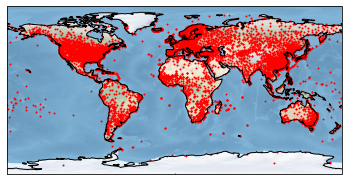

In [24]:
# Plot stations in our dataset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata0.lon],[metadata0.lat],color='r',marker='o',s=1.0)
plt.show()

TypeError: sequence item 0: expected str instance, Series found

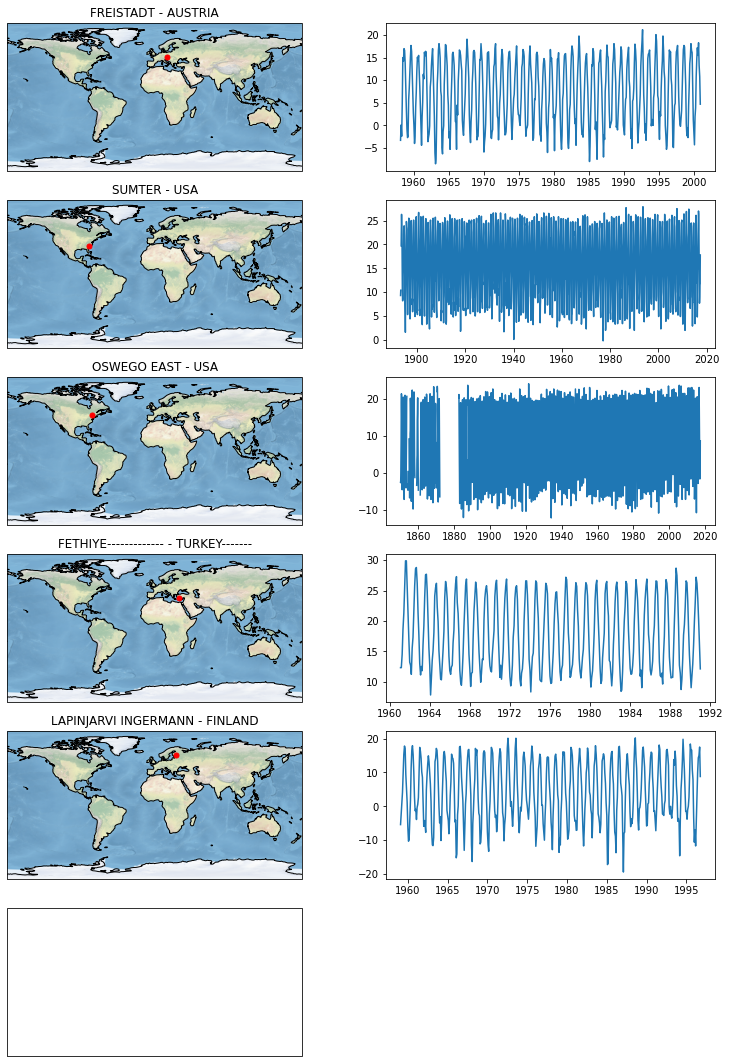

In [25]:
#-- Plot time series from a few randomly chosen stations --

#- Set multipanel plot
fig = plt.figure(figsize=(13,19))

no = 6   # number of randomn stations to pick

subplots = (no,2)
n_panels = subplots[0] * subplots[1]

proj = ccrs.PlateCarree()

#- Select sites
rssite = np.random.randint(len(data0.columns), size=no)
ssite = metadata0.index[rssite]

for fi, f in enumerate(ssite):

    #- locate on map
    ax = fig.add_subplot(subplots[0], subplots[1], (fi*2)+1, projection=proj)
    ax.set_title(' - '.join([metadata0.stname[ssite[fi]],metadata0.country[ssite[fi]]]))
    ax.stock_img()
    ax.coastlines()
    plt.plot(metadata0.lon[ssite[fi]], metadata0.lat[ssite[fi]],
         color='red', marker='o', markersize=5,
         transform=ccrs.Geodetic())         
 
    #- time series
    tser = fig.add_subplot(subplots[0], subplots[1], (fi+1)*2)
    #data0[ssite[fi]].plot()  
    plt.plot(data0[ssite[fi]])

fig.tight_layout()
plt.show()

In [ ]:
# Then let's start exploting our datasets towards the final goal
# (1) Deal with the time series, in particular what do about missing data (nothing or anything else?)
# (2) Transform all TEMPERATURE time series to TEMPERATURE ANOMALY time series, with respect to a reference period
# (3) First step of spatial aggregation: gridding at monthly time step
# (4) Aggregate the gridded data from monthly to annual time step
# (5) Second step of spatial aggregation: derive the global time series from the gridded dataset

In [ ]:
# (1) Deal with the time series, in particular what to do about missing data 

# We could decide 
#   to retain only stations with complete records, 
#   or to retain for every station only the years with at least 6 months of data, etc.
# We could also decide e.g.
#   to assign the missing data based on the nearest (in time) value for the same month at the same station
#   or to assign the missing data based on the nearest (in space) value for the same month from a different station

# In this example I will just go on without further pre-processing operations

In [26]:
# (2) Transform all TEMPERATURE time series to TEMPERATURE ANOMALY time series, with respect to a reference period

# ANOMALY(y,m) = DATA(y,m) - AVERAGE[ref. period](m) , for each month (m=1..12), for each year (y=1850..2019)

# AVERAGE[ref. period](m) is in fact the "Normals", that we could have stored while acquiring the data & metadata, or
#  alternatively we could recalculate here. I will show how to proceed for the second option.

In [27]:
# First, let's identify the position along the time index that corresponds to the begining/end of the reference period

x1=data0.index.get_loc('1961-01-31')
x2=data0.index.get_loc('1990-12-31')

# Then calculate the "Normals"

data_normals = data0[x1:x2].groupby(data0[x1:x2].index.month).mean()
print(data_normals)

       612913_x   612770_x   614010_x   618470_x   614420_x   618810_x  \
time                                                                     
1     25.065217  23.843333  16.984615  22.718519  21.124138  25.992857   
2     27.926087  26.900000  18.813043  24.477778  22.738462  26.996429   
3     30.326087  30.096667  21.162500  25.544444  24.131034  27.842857   
4     31.331818  32.703333  21.807692  25.574074  24.337037  27.788889   
5     30.459091  33.113333  24.057692  25.240741  25.381481  27.011538   
6     28.004545  30.633333  27.025000  24.440741  26.792857  26.311111   
7     25.636364  28.123333  32.137500  23.696429  26.903704  25.303846   
8     24.918182  27.033333  31.518519  23.651852  28.138462  25.046154   
9     25.622727  27.503333  30.000000  24.042857  29.244444  25.625926   
10    27.178261  29.170000  25.479167  24.310714  28.526923  26.228571   
11    27.365217  27.526667  20.743478  23.960714  25.270833  26.428571   
12    25.313043  24.275862  16.370833 

In [28]:
# Finally, let's subtract normals from the the original time series, to get 
# the time series of the temperature anomalies for each station 
# (Note that this operation would be efficiently done with 2D data organization, such as in the original text files)

# Make a copy of data0 (data_anom) to store the anomalies

data_anom = data0

# Then loop through all the years (January) in the time axis, and substract the Normals from each chunk of 12 months

y0=0
for yi in range(0,int(nyears)):
  data_anom.iloc[y0:y0+12,:] = data0.iloc[y0:y0+12,:]-np.array(data_normals.iloc[:,:])
  y0+=12

KeyboardInterrupt: 

In [ ]:
#-- Plot time series from a few randomly chosen stations --

#- Set multipanel plot
fig = plt.figure(figsize=(13,19))

no = 6   # number of randomn stations to pick

subplots = (no,2)
n_panels = subplots[0] * subplots[1]

proj = ccrs.PlateCarree()

#- Select sites
rssite = np.random.randint(len(data0.columns), size=no)
ssite = metadata0.index[rssite]

for fi, f in enumerate(ssite):

    #- locate on map
    ax = fig.add_subplot(subplots[0], subplots[1], (fi*2)+1, projection=proj)
    ax.set_title(' - '.join([metadata0.stname[ssite[fi]],metadata0.country[ssite[fi]]]))
    ax.stock_img()
    ax.coastlines()
    plt.plot(metadata0.lon[ssite[fi]], metadata0.lat[ssite[fi]],
         color='red', marker='o', markersize=5,
         transform=ccrs.Geodetic())         
 
    #- time series
    tser = fig.add_subplot(subplots[0], subplots[1], (fi+1)*2)
    #data0[ssite[fi]].plot()  
    plt.plot(data_anom[ssite[fi]])

fig.tight_layout()
plt.show()

In [ ]:
# (3) First step of spatial aggregation: gridding at monthly time step

# All data are aggregated (averaged) in a regular lat/lon grid covering the Earth surface (e.g. 10x10 or 5x5 deg.)
# In this way, we are "homogenizing" the spatial distribution of our dataset

# Here there are a few strategies that can be followed. 

# One way would be to build a grid (e.g. a couple of 1D lists/arrays or one 2D array) containing the 
#  lats/lons margins of grid cells. Then slicing based on lats and lons ranges can be used to calculate the average
#  time series from the grid cell.

# A similar approach could be devised using geopandas, attributing lat/lon station coordinates to point geometries, 
#  defining the regular grid as a series of polygons. Then it would be possible to use geopandas geometry functions
#  to operate a "geometry slicing", i.e. points contained within a given polygon.
#  http://blog.yhat.com/posts/interactive-geospatial-analysis.html

In [ ]:
# (4) Aggregate the gridded data from monthly to annual time step

# By doing this operation after (3), we are in fact still exploiting data from stations with some missing data

In [ ]:
# In this phase we can either
# - consider all data, irrespective of the fact that a given year has NAN for ceratin values
# - or set to NAN all incomplete years

In [ ]:
# I will proceed in this example, using the first strategy, for both (3) and (4)

In [ ]:
# create grid 

resol = 20 #5  # degrees (E and N)
nlon = np.int(360/resol)
nlat = np.int(180/resol)

# define grid cell margins

grlons = np.empty([nlon+1],dtype='float') 
grlats = np.empty([nlat+1],dtype='float') 
grlons[0] = -180.
grlats[0] = -90.
for i in range(1,nlon+1):
  grlons[i]=grlons[i-1]+resol
for i in range(1,nlat+1):
  grlats[i]=grlats[i-1]+resol

In [ ]:
# Create data structure to host the gridded dataset:
# what will it be ?  -> I chose 3D numpy array

data_mo = np.empty([nmonths,nlat,nlon],dtype=float)
data_mo[:,:,:] = np.nan

data_yr = np.empty([int(nyears),nlat,nlon],dtype=float)
data_yr[:,:,:] = np.nan

In [ ]:
# Iterate over grid cells and 
# - get the average time series of all stations in grid cell at monthy resolution
# - integrate to annual resolutin  

for j in range(0,nlat):
  for i in range(0,nlon):
    
    dummy = metadata0[metadata0.lon >= grlons[i]]
    dummy = dummy[dummy.lon < grlons[i+1]]
    dummy = dummy[dummy.lat >= grlats[j]]
    dummy = dummy[dummy.lat < grlats[j+1]]

    #print('*',grlons[i],grlons[i+1],grlats[j],grlats[j+1])
    #print(dummy.index)

    if (len(dummy.index) > 0):
 
      # calculation

      data_mo[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1)).flatten()
        
      data_yr[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1).resample("Y").mean()).flatten()

      # display to check things  

      fig = plt.figure(figsize=(13,3))  
      subplots = (1,2)
      n_panels = subplots[0] * subplots[1]

      #- locate on map
      ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
      ax.stock_img()
      ax.coastlines()
      ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))
      ax.scatter([dummy.lon],[dummy.lat],color='r',marker='o',s=1.2)
         
      #- time series
      tser = fig.add_subplot(subplots[0], subplots[1], 2)
      plt.plot(taxis,data_anom[dummy.index],color='grey',linewidth=0.1)
      plt.plot(taxis,data_mo[:,j,i],color='blue',linewidth=0.3)
      plt.plot(pd.date_range('1850-01', '2019-01', freq='Y'),data_yr[:,j,i],color='red',linewidth=2)  

      fig.tight_layout()  
      plt.show()   

In [ ]:
# (5) Second step of spatial aggregation: derive the global time series from the gridded dataset

In [ ]:
# Here we have the options of a simple arithmetic average, or a weighted average
# The weights could be on several levels, e.g.
# - a measure of the density of observations or their coherence
# - the unequal areas covered by each grid cell
# - the unequal proportions of land vs ocean in different grid cells
# - ...

In [ ]:
# In this case, I will simply use the arithmetic average

In [ ]:
# Prepare to display to check things  

fig = plt.figure(figsize=(13,13))  
subplots = (2,1)

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

tser = fig.add_subplot(subplots[0], subplots[1], 2)

# Initialize data structure to host global average temperature anomaly time series

data_glob = np.empty([int(nyears)],dtype=float)
data_glob[:] = np.nan

# loop over all grid cells

for j in range(0,nlat):
  for i in range(0,nlon):
    
    # Check if current grid cell has an associated time series
    
    if not(np.isnan(data_yr[:,j,i]).all()):
     
      #  place a marker on the map, and plot individual grid cell time series 

      ax.plot( grlons[i:i+2].sum()/2, grlats[j:j+2].sum()/2,
         color='red', marker='x', markersize=5,transform=ccrs.PlateCarree())     
      plt.plot(pd.date_range('1850-01', '2019-01', freq='Y'),data_yr[:,j,i],color='gray',linewidth=0.1) 

# calculate the global average at each time step      
        
for t in range(0,int(nyears)):  

    local = data_yr[t,:,:]
    valid = np.isnan(data_yr[t,:,:])
    data_glob[t] = np.nanmean(local[~valid])

# plot the global average curve  
    
plt.plot(pd.date_range('1850-01', '2019-01', freq='Y'),data_glob[:],color='red',linewidth=2) 

fig.tight_layout()  
plt.show() 

In [ ]:
# print to file the time series of global mean temperature anomalies

gmta = pd.DataFrame({'time': pd.date_range('1850-01', '2019-01', freq='Y')})
gmta['gmta'] = data_glob[:]
gmta = gmta.set_index(['time'])

gmta.to_csv('_'.join(['gmta',str(int(nst_tmp)),'stations']))

In [ ]:
# Note that estimation of uncertainties in the different passages could be calculated, and propagated
# Also, it would be possible to perform several realizations of selecting sub-gropus of stations (bootstrap)
# Several "cleaning" / pre-processing operations could be considered, e.g. removal of outliers (e.g. > n St.dev.)